In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

In [12]:
original_data = pd.read_csv('datasets/car.data', header=None)
original_data.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
original_data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


In [13]:
reduced_data, _ = train_test_split(original_data, train_size = 150, stratify=original_data['class'], random_state=42)
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 1515 to 844
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    150 non-null    object
 1   maint     150 non-null    object
 2   doors     150 non-null    object
 3   persons   150 non-null    object
 4   lug_boot  150 non-null    object
 5   safety    150 non-null    object
 6   class     150 non-null    object
dtypes: object(7)
memory usage: 9.4+ KB


In [14]:
# save reduced data for further assignment
reduced_data.to_excel('datasets/reduced_data.xlsx')

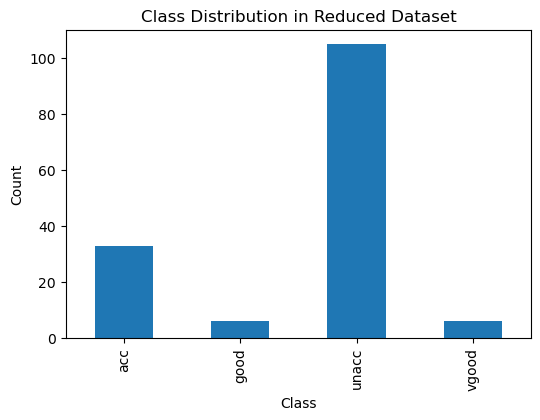

In [15]:
plt.figure(figsize=(6, 4))
reduced_data['class'].value_counts().sort_index().plot(kind='bar')
plt.title("Class Distribution in Reduced Dataset")
plt.xlabel('Class')
plt.ylabel("Count")
plt.show()

# Training

In [16]:
train_data, test_data = train_test_split(reduced_data, test_size = 0.3, random_state=42)

# save train and test data for further assignment
train_data.to_excel('datasets/train_data.xlsx')
test_data.to_excel('datasets/test_data.xlsx')

In [17]:
naive_bayes = {} # initialize dictionary to contain all possibilities

# calculate label bayes
label = {}
label_grouped = train_data.groupby('class')
for name, data in label_grouped:
    bayes = data.shape[0] / train_data.shape[0]
    label[name] = bayes
naive_bayes['class'] = label

train_feature = train_data.drop('class', axis=1)
columns = train_feature.columns

# calculate features bayes
labels = train_data['class'].unique()
for column in columns:
    feature_cross = pd.crosstab(train_data[column], train_data['class'], margins=True).unstack().reorder_levels((column, 'class'))
    feature_categories = train_data[column].unique()
    column_bayes = {}
    for category in feature_categories:
        category_bayes = {}
        for label in labels:
            bayes = float(feature_cross.loc[category, label] / feature_cross.loc['All', label])
            category_bayes[label] = bayes
        column_bayes[category] = category_bayes
    naive_bayes[column] = column_bayes

# Test Model

In [18]:
predictions = []
true_labels = []
labels = ['unacc', 'acc', 'good', 'vgood']
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
for i in test_data.index:
    row = test_data.loc[i]
    pred = ''
    likelihood = 0
    for label in labels:
        bayes = 1
        for column in columns:
            bayes *= naive_bayes[column][row[column]][label]
        bayes *= naive_bayes['class'][label]
        if bayes > likelihood:
            pred = label
            likelihood = bayes
    predictions.append(pred)
    true_labels.append(row['class'])

# Confusion Matrix

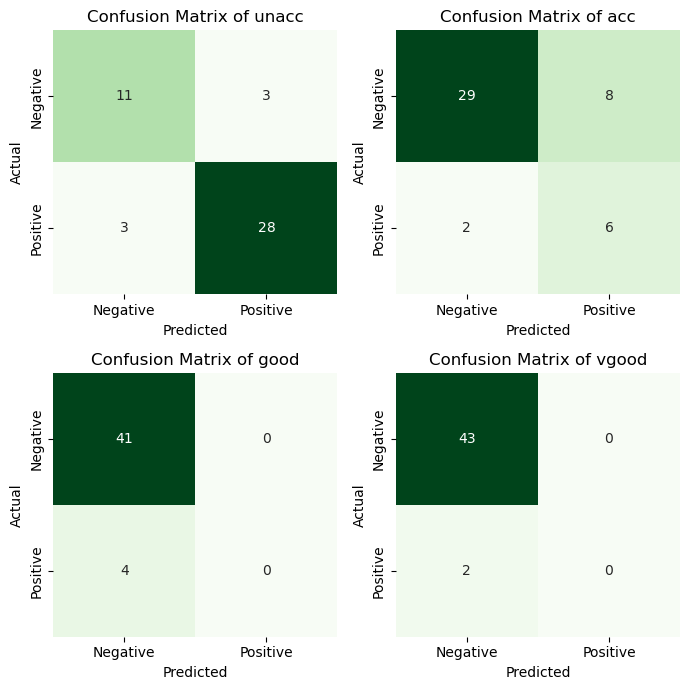

In [19]:
cm = multilabel_confusion_matrix(true_labels, predictions, labels=labels)
cm_labels = ['Negative', 'Positive']
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.ravel()

for i in range(4):
    cm_df = pd.DataFrame(cm[i], index=cm_labels, columns=cm_labels)
    sns.heatmap(cm_df, annot=True, cmap='Greens', ax=axes[i], cbar=False)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    title = "Confusion Matrix of " + labels[i]
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

In [20]:
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7555555555555555
